# 使用PINNs求解Kovasznay流问题

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindflow/zh_cn/physics_driven/mindspore_kovasznay.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindflow/zh_cn/physics_driven/mindspore_kovasznay.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/r2.5.0/docs/mindflow/docs/source_zh_cn/physics_driven/kovasznay.ipynb)


## 问题描述

本案例演示如何利用PINNs求解``Kovasznay``流问题。``Kovasznay``流是``Navier-Stokes（N-S）``方程的一个特定条件下的解析解。``Kovasznay``流满足``N-S``方程的动量方程和连续性方程，并且满足``Dirichlet``边界条件。

``Kovasznay``流的速度和压力分布可以表示为以下公式：

$$
u=1-e^{\lambda x}\cos{(2\pi y)}.
$$

$$
v=\frac{\lambda}{2\pi}e^{\lambda x}\sin(2\pi x).
$$

$$
p = \frac{1}{2}(1-e^{2\lambda x}).
$$

其中，$\lambda=\frac{1}{2\nu}-\sqrt{\frac{1}{4\nu^2}+4\pi^2}$。

我们可以将Kovasznay流作为一个基准解，用于验证``PINNs``方法的准确性和稳定性。

## 技术路径

MindSpore Flow求解该问题的具体流程如下：

1. 创建训练数据集。
2. 构建模型。
3. 优化器。
4. 约束。
5. 模型训练。
6. 模型评估。

In [1]:
import time

from mindspore import context, nn, ops, jit
from mindflow import load_yaml_config
from mindflow.cell import FCSequential
from mindflow.loss import get_loss_metric
from mindspore import load_checkpoint, load_param_into_net, save_checkpoint

from src.dataset import create_dataset


context.set_context(mode=context.GRAPH_MODE, save_graphs=False, device_target="GPU")

# Load config
file_cfg = "kovasznay_cfg.yaml"
config = load_yaml_config(file_cfg)

## 创建数据集

本案例在求解域及边值条件进行随机采样，生成训练数据集与测试数据集。具体方法见[src/dataset.py](https://gitee.com/mindspore/mindscience/blob/r0.7/MindFlow/applications/physics_driven/navier_stokes/kovasznay/src/dataset.py)。

In [2]:
ds_train = create_dataset(config)

## 构建模型

本示例使用一个简单的全连接网络，深度为4层，每层的神经元个数为50，激活函数为tanh。

In [3]:
model = FCSequential(
    in_channels=config["model"]["in_channels"],
    out_channels=config["model"]["out_channels"],
    layers=config["model"]["layers"],
    neurons=config["model"]["neurons"],
    residual=config["model"]["residual"],
    act="tanh",
)

In [4]:
if config["load_ckpt"]:
    param_dict = load_checkpoint(config["load_ckpt_path"])
    load_param_into_net(model, param_dict)

params = model.trainable_params()
optimizer = nn.Adam(params, learning_rate=config["optimizer"]["initial_lr"])

## Kovasznay 求解器

下述Kovasznay将作为约束条件，用于求解Kovasznay流问题。
包含两个部分，分别为Kovasznay流方程和边界条件。

边界条件根据上述参考解进行设置。

In [5]:
import sympy
from sympy import Function, diff, symbols
from mindspore import numpy as ms_np
from mindflow import PDEWithLoss, sympy_to_mindspore
import math

class Kovasznay(PDEWithLoss):
    """Define the loss of the Kovasznay flow."""

    def __init__(self, model, re=20, loss_fn=nn.MSELoss()):
        """Initialize."""
        self.re = re
        self.nu = 1 / self.re
        self.l = 1 / (2 * self.nu) - math.sqrt(
            1 / (4 * self.nu**2) + 4 * math.pi**2
        )
        self.x, self.y = symbols("x y")
        self.u = Function("u")(self.x, self.y)
        self.v = Function("v")(self.x, self.y)
        self.p = Function("p")(self.x, self.y)
        self.in_vars = [self.x, self.y]
        self.out_vars = [self.u, self.v, self.p]
        super(Kovasznay, self).__init__(model, self.in_vars, self.out_vars)
        self.bc_nodes = sympy_to_mindspore(self.bc(), self.in_vars, self.out_vars)
        if isinstance(loss_fn, str):
            self.loss_fn = get_loss_metric(loss_fn)
        else:
            self.loss_fn = loss_fn

    def pde(self):
        """Define the gonvering equation."""
        u, v, p = self.out_vars
        u_x = diff(u, self.x)
        u_y = diff(u, self.y)
        v_x = diff(v, self.x)
        v_y = diff(v, self.y)
        p_x = diff(p, self.x)
        p_y = diff(p, self.y)
        u_xx = diff(u_x, self.x)
        u_yy = diff(u_y, self.y)
        v_xx = diff(v_x, self.x)
        v_yy = diff(v_y, self.y)
        momentum_x = u * u_x + v * u_y + p_x - (1 / self.re) * (u_xx + u_yy)
        momentum_y = u * v_x + v * v_y + p_y - (1 / self.re) * (v_xx + v_yy)
        continuty = u_x + v_y
        equations = {
            "momentum_x": momentum_x,
            "momentum_y": momentum_y,
            "continuty": continuty,
        }
        return equations

    def u_func(self):
        """Define the analytical solution."""
        u = 1 - sympy.exp(self.l * self.x) * sympy.cos(2 * sympy.pi * self.y)
        return u

    def v_func(self):
        """Define the analytical solution."""
        v = (
            self.l
            / (2 * sympy.pi)
            * sympy.exp(self.l * self.x)
            * sympy.sin(2 * sympy.pi * self.y)
        )
        return v

    def p_func(self):
        """Define the analytical solution."""
        p = 1 / 2 * (1 - sympy.exp(2 * self.l * self.x))
        return p

    def bc(self):
        """Define the boundary condition."""
        bc_u = self.u - self.u_func()
        bc_v = self.v - self.v_func()
        bc_p = self.p - self.p_func()
        bcs = {"u": bc_u, "v": bc_v, "p": bc_p}
        return bcs

    def get_loss(self, pde_data, bc_data):
        """Define the loss function."""
        pde_res = self.parse_node(self.pde_nodes, inputs=pde_data)
        pde_residual = ops.Concat(axis=1)(pde_res)
        pde_loss = self.loss_fn(pde_residual, ms_np.zeros_like(pde_residual))
        bc_res = self.parse_node(self.bc_nodes, inputs=bc_data)
        bc_residual = ops.Concat(axis=1)(bc_res)
        bc_loss = self.loss_fn(bc_residual, ms_np.zeros_like(bc_residual))
        return pde_loss + bc_loss


# Create the problem
problem = Kovasznay(model)

momentum_x: u(x, y)*Derivative(u(x, y), x) + v(x, y)*Derivative(u(x, y), y) + Derivative(p(x, y), x) - 0.05*Derivative(u(x, y), (x, 2)) - 0.05*Derivative(u(x, y), (y, 2))
    Item numbers of current derivative formula nodes: 5
momentum_y: u(x, y)*Derivative(v(x, y), x) + v(x, y)*Derivative(v(x, y), y) + Derivative(p(x, y), y) - 0.05*Derivative(v(x, y), (x, 2)) - 0.05*Derivative(v(x, y), (y, 2))
    Item numbers of current derivative formula nodes: 5
continuty: Derivative(u(x, y), x) + Derivative(v(x, y), y)
    Item numbers of current derivative formula nodes: 2
u: u(x, y) - 1 + exp(-1.81009812001397*x)*cos(2*pi*y)
    Item numbers of current derivative formula nodes: 3
v: v(x, y) + 0.905049060006983*exp(-1.81009812001397*x)*sin(2*pi*y)/pi
    Item numbers of current derivative formula nodes: 2
p: p(x, y) - 0.5 + 0.5*exp(-3.62019624002793*x)
    Item numbers of current derivative formula nodes: 3


## 模型训练

使用MindSpore>= 2.0.0的版本，可以使用函数式编程范式训练神经网络。

In [6]:
def train(config):
    grad_fn = ops.value_and_grad(
        problem.get_loss, None, optimizer.parameters, has_aux=False
    )

    @jit
    def train_step(pde_data, bc_data):
        loss, grads = grad_fn(pde_data, bc_data)
        loss = ops.depend(loss, optimizer(grads))
        return loss

    def train_epoch(model, dataset, i_epoch):
        model.set_train()
        n_step = dataset.get_dataset_size()
        for i_step, (pde_data, bc_data) in enumerate(dataset):
            local_time_beg = time.time()
            loss = train_step(pde_data, bc_data)

            if i_step % 50 == 0:
                print(
                    "\repoch: {}, loss: {:>f}, time elapsed: {:.1f}ms [{}/{}]".format(
                        i_epoch,
                        float(loss),
                        (time.time() - local_time_beg) * 1000,
                        i_step + 1,
                        n_step,
                    )
                )

    for i_epoch in range(config["epochs"]):
        train_epoch(model, ds_train, i_epoch)

    if config["save_ckpt"]:
        save_checkpoint(model, config["save_ckpt_path"])

In [7]:
time_beg = time.time()
train(config)
print("End-to-End total time: {} s".format(time.time() - time_beg))

epoch: 0, loss: 0.239163, time elapsed: 9470.9ms [1/125]
epoch: 0, loss: 0.087055, time elapsed: 44.7ms [51/125]
epoch: 0, loss: 0.086475, time elapsed: 45.2ms [101/125]
epoch: 1, loss: 0.085488, time elapsed: 47.1ms [1/125]
epoch: 1, loss: 0.087387, time elapsed: 45.5ms [51/125]
epoch: 1, loss: 0.083520, time elapsed: 45.2ms [101/125]
epoch: 2, loss: 0.083846, time elapsed: 47.5ms [1/125]
epoch: 2, loss: 0.082749, time elapsed: 45.1ms [51/125]
epoch: 2, loss: 0.081391, time elapsed: 46.2ms [101/125]
epoch: 3, loss: 0.081744, time elapsed: 47.2ms [1/125]
epoch: 3, loss: 0.080608, time elapsed: 45.8ms [51/125]
epoch: 3, loss: 0.082139, time elapsed: 45.1ms [101/125]
epoch: 4, loss: 0.080847, time elapsed: 47.6ms [1/125]
epoch: 4, loss: 0.083495, time elapsed: 46.0ms [51/125]
epoch: 4, loss: 0.083020, time elapsed: 45.3ms [101/125]
epoch: 5, loss: 0.079421, time elapsed: 76.9ms [1/125]
epoch: 5, loss: 0.062890, time elapsed: 44.6ms [51/125]
epoch: 5, loss: 0.018953, time elapsed: 45.2ms 

In [8]:
from src import visual, calculate_l2_error

## 模型预测可视化

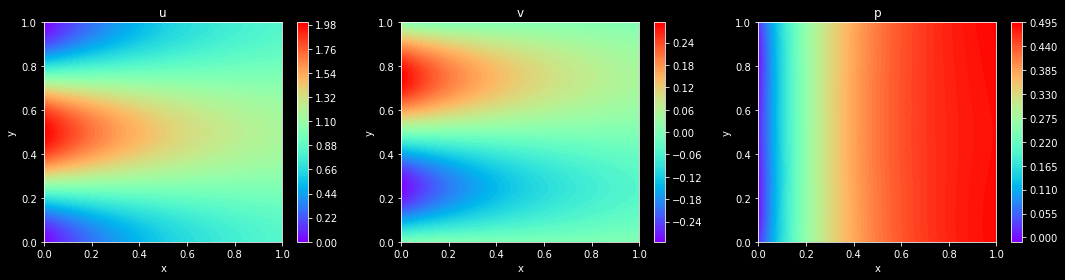

In [9]:
visual(model, config, resolution=config["visual_resolution"])

## 模型评估

In [12]:
n_samps = 10000  # Number of test samples
ds_test = create_dataset(config, n_samps)
calculate_l2_error(problem, model, ds_test)

u: 1 - exp(-1.81009812001397*x)*cos(2*pi*y)
    Item numbers of current derivative formula nodes: 2
v: -0.905049060006983*exp(-1.81009812001397*x)*sin(2*pi*y)/pi
    Item numbers of current derivative formula nodes: 1
p: 0.5 - 0.5*exp(-3.62019624002793*x)
    Item numbers of current derivative formula nodes: 2
Relative L2 error on domain: 0.003131713718175888
Relative L2 error on boundary: 0.0069109550677239895
